# Bandpass Signals and Filters

The following code cell contains a custom Python function to plot the line spectra of signals in the frequency domain. Click "Run All" when running the notebook for the first time.

**Note 1:** When taking Fourier transform, in most cases, only the magnitude spectrum is of interest because it shows the shape of the transform, and which frequencies are present. 

**Note 2:** When taking the Fourier transform using the FFT function in any software, FFT needs to be scaled. The reason for this explained [in this blog.](https://sites.psu.edu/charlesammon/2017/03/09/how-to-determine-fft-scaling-with-matlab/) 

**Note 2.1:** For periodic signals, the FFT needs to be scaled by the length of the time array `n = len(t)`, probably because the signal is continuous over the entire time array.

**Note 2.2:** For aperiodic signals, the FFT needs to be scaled by time step of the time array `dt = t[1]-t[0]`, probably because the signal only exists for a finite portion of the time array.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Define a generic unit step function
def u(t):
    x = np.zeros(len(t))
    # tt keeps track of the value of t while the loop iterates
    # tt is equivalent to t[i]
    for i, tt in enumerate(t):
        if tt > 0:
            x[i] = 1.0
    return x

# Define function for creating a rectangular pulse
# where tau = pulse width and 
# the pulse is active over -tau/2 <= t <= tau/2.
def rect(t,tau):
    x = np.zeros(len(t))
    for i, tt in enumerate(t):
        if (np.abs(tt)>tau/2):
            x[i] = 0
        else:
            x[i] = 1
    return x

# Define a simulated delta function using step functions
def delta(t):
    x = np.zeros(len(t))
    # Td is the pulse width set equal to the time step
    Td = t[1]-t[0]
    # The amplitude is set to 1/Td, so that area under
    # the pulse is unity.
    x = (1/Td)*(u(t)-u(t-Td))
    return x   

# Create time axis
t = np.linspace(-2,2,2048)

# Create the frequency axis
dt = t[1]-t[0]
N = len(t)
# The fftshift function will center the 0th frequency.
freq = np.fft.fftshift(np.fft.fftfreq(N,dt)) 

## Ideal low pass filter
A ideal low pass filter is one that allows the input frequencies within the bandwidth to pass without distorion, and rejects input frequencies outside the bandwidth.

There can be two versions of this filter depending on its phase response.

### Without time delay

#### Transfer function (frequency domain representation)
The transfer function of an ideal low pass filter without time delay can be defined as
$$
\begin{align*}
H(f) = \begin{cases}
& K, &\ -B\leq f\leq B\\
& 0, &\ |f|>B 
\end{cases}
\end{align*}
$$
where $K$ is the filter gain (typically normalized to 1), and $B$ is the desired bandwidth.

#### Impulse response (time domain representation)
Taking the inverse Fourier transform (IFT) of $H(f)$ yields the impulse reponse given below:
$$
\begin{align*}
h(t) &= \int_{-\infty}^{\infty}H(f)e^{j2\pi ft}df\\
\\
&= \int_{-B}^{B}K e^{j2\pi ft}df\\
\\
&= K\left[\dfrac{e^{j2\pi ft}}{j2\pi t}\right]_{-B}^{B}\\
\\
&= \dfrac{K}{\pi t}\left[\dfrac{e^{j2\pi Bt}-e^{-j2\pi Bt}}{2j}\right]\\
\\
&= K\dfrac{\sin(\pi 2Bt)}{\pi t}\\
\\
&= 2KB\dfrac{\sin(\pi 2Bt)}{\pi 2Bt}\\
\end{align*}
$$
Assume $K=1$,
$$
h(t) = 2B\,\mathrm{sinc}\left(2Bt\right)
$$

The rectangle transfer function in frequency domain becomes an infinitely long sinc pulse, centered at $t=0$ in time domain.

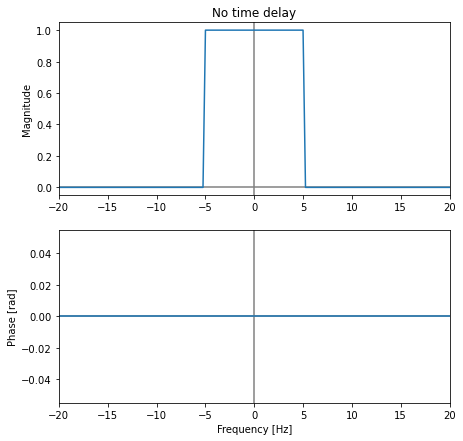

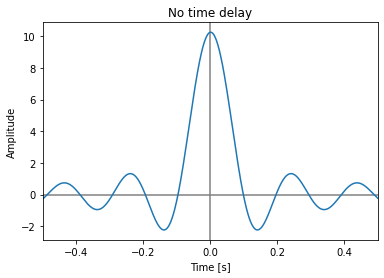

In [2]:
# Define the filter transfer function
K = 1.0         # Filter gain
B = 5           # Bandwidth
t0 = 0# 1/(2*B)    # Time delay 

rect_f = K*rect(freq,2*B)      # Total width of band is 2B
H_f = rect_f*np.exp(-1j*2*np.pi*freq*t0)

# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('No time delay')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(H_f))
plt.ylabel('Magnitude')
plt.xlim([-20,20])

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.angle(H_f))
plt.ylabel('Phase [rad]')
plt.xlim([-20,20])

plt.xlabel('Frequency [Hz]')
plt.show()


# Find the impulse response by taking IFFT of H(f)
h_t = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H_f)))*N/4

# Plot the signal
plt.title('No time delay')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,np.real(h_t))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(-0.5,0.5)
plt.show()

### With time delay

#### Transfer function (frequency domain representation)
The transfer function of an ideal low pass filter with time delay can be defined as
$$
\begin{align*}
H(f) = \begin{cases}
& K\,\ e^{\left(-j2\pi ft_{0}\right)}, &\ -B\leq f\leq B\\
& 0, &\ |f|>B 
\end{cases}
\end{align*}
$$
where $K$ is the filter gain (typically normalized to 1), $B$ is the desired bandwidth, and $t_{0}$ is the amount of delay the input signal undergoes before it reaches the output.

#### Impulse response (time domain representation)
Taking the inverse Fourier transform (IFT) of $H(f)$ yields the impulse reponse given below:
$$
\begin{align*}
h(t) &= \int_{-\infty}^{\infty}H(f)e^{j2\pi ft}df\\
\\
&= \int_{-B}^{B}K e^{-j2\pi ft_{0}} e^{j2\pi ft}df\\
\\
&= K\int_{-B}^{B} e^{j2\pi f(t-t_{0})}df\\
\\
&= K\left[\dfrac{e^{j2\pi f(t-t_{0})}}{j2\pi (t-t_{0})}\right]_{-B}^{B}\\
\\
&= \dfrac{K}{\pi (t-t_{0})}\left[\dfrac{e^{j2\pi B(t-t_{0})}-e^{-j2\pi B(t-t_{0})}}{2j}\right]\\
\\
&= K\dfrac{\sin(\pi 2B(t-t_{0}))}{\pi (t-t_{0})}\\
\\
&= 2KB\dfrac{\sin(\pi 2B(t-t_{0}))}{\pi 2B(t-t_{0})}\\
\end{align*}
$$
Assume $K=1$,
$$
h(t) = 2B\,\mathrm{sinc}\left(2B(t-t_{0})\right)
$$

The rectangle transfer function in frequency domain becomes an infinitely long sinc pulse, centered at $t=t_{0}$ in time domain.

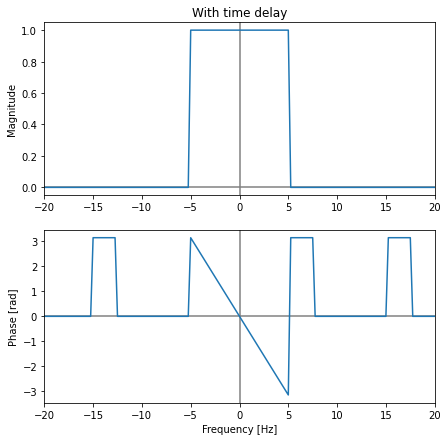

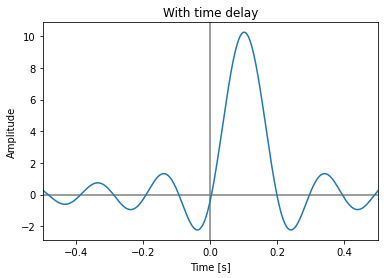

In [3]:
# Define the filter transfer function
K = 1.0         # Filter gain
B = 5           # Bandwidth
t0 = 1/(2*B)    # Time delay 

rect_f = K*rect(freq,2*B)      # Total width of band is 2B
H_td_f = rect_f*np.exp(-1j*2*np.pi*freq*t0)

# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('With time delay')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(H_td_f))
plt.ylabel('Magnitude')
plt.xlim([-20,20])

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.angle(H_td_f))
plt.ylabel('Phase [rad]')
plt.xlim([-20,20])

plt.xlabel('Frequency [Hz]')
plt.show()

# Find the impulse response by taking IFFT of H(f)
h_td_t = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H_td_f)))*N/4

# Plot the signal
plt.title('With time delay')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,np.real(h_td_t))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(-0.5,0.5)
plt.show()


## Approximate the ideal filter
Ideal filters are not physically realizable because their impulse response is non-causal and infinite in time.

To make approximate the response of an ideal filter:

1. Increase the time-shift to make a filter causal

2. Truncate the impulse response, so that it is finite.

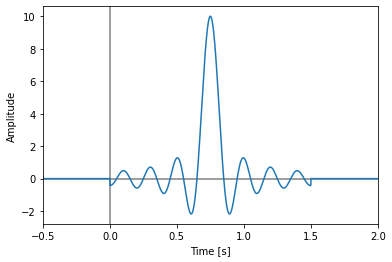

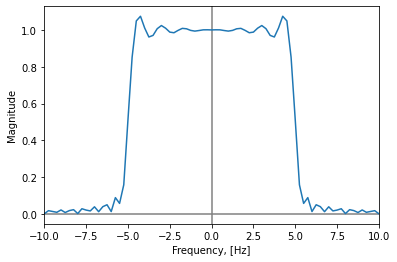

In [4]:
# Define a sinc centered at t = 10t0
s_t = 2*B*np.sinc(2*B*(t-7.5*t0))*(u(t)-u(t-1.5))

# Plot the signal
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,s_t)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([-0.5,2])
plt.show()

# Calculate FFT. 
S_f = np.fft.fftshift(np.fft.fft(s_t))*dt

# Plot the magnitude spectrum
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(S_f))
plt.xlim([-10,10])
plt.xlabel('Frequency, [Hz]')
plt.ylabel('Magnitude')
plt.show()

## Low pass filter response to low pass input signal
Consider a low pass rectangular pulse of duration $t_{d}$, and amplitude $A$.
$$
x_{LP}(t) = \begin{cases}
& A,&\ \mathrm{for}\ |t|<\dfrac{t_{d}}{2}\\
& 0,&\ \mathrm{otherwise}
\end{cases}
$$
is passed through a low pass filter having impulse response
$$
h_{LP}(t) = 2B\,\mathrm{sinc}(2B\,t)
$$
where $B$ is the filter bandwidth.

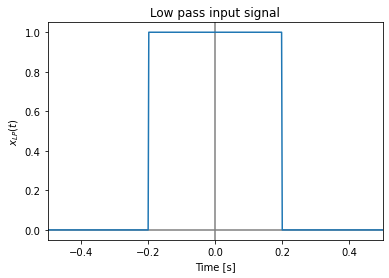

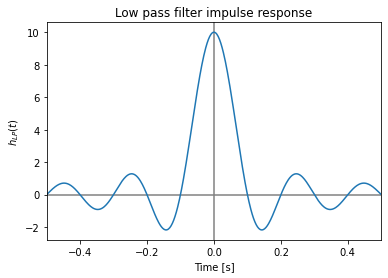

In [5]:
# Define a rectangular pulse centered at t=0
A = 1.0         # Amplitude
T = 0.4         # pulse width
xl_t = A*rect(t,T)

# Plot the signal
plt.title('Low pass input signal')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,xl_t)
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$x_{LP}(t)$')
plt.show()

# Define the filter transfer function
K = 1.0         # Filter gain
B = 5           # Bandwidth

# Define a sinc centered at t = 0
hl_t = 2*B*np.sinc(2*B*t)

# Plot the signal
plt.title('Low pass filter impulse response')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,hl_t)
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$h_{LP}(t)$')
plt.show()

The Fourier transform of the low pass input will be 
$$
X_{LP}(f) = At_{d}\mathrm{sinc}(ft_{d})
$$
and the Fourier transform for the low pass filter will be
$$
H_{LP}(f) = \begin{cases}
& 1,&\ -B<f<B\\
& 0,&\ |f|>B
\end{cases}
$$

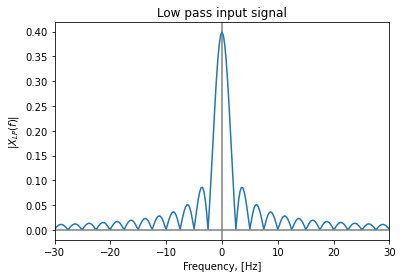

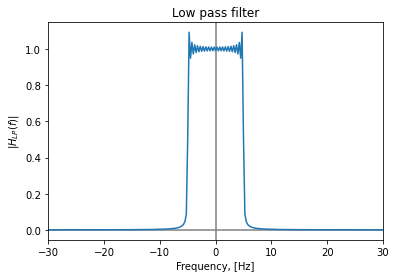

In [6]:
# Calculate FFT.
Xl_f = np.fft.fftshift(np.fft.fft(xl_t))*dt
Hl_f = np.fft.fftshift(np.fft.fft(hl_t))*dt

# Plot the magnitude spectrum
plt.title('Low pass input signal')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(Xl_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|X_{LP}(f)|$')
plt.show()

# Plot the magnitude spectrum
plt.title('Low pass filter')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(Hl_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|H_{LP}(f)|$')
plt.show()

#### Low pass output response
The output response can be determined by multiplying the Fourier transforms of the input pulse and the filter.
$$
\begin{align*}
Y_{LP}(f) &= X_{LP}(f)\, H_{LP}(f)\\
&= \begin{cases}
& At_{d}\mathrm{sinc}(ft_{d}),&\ -B<t<B\\
&0,&\ |f|>B
\end{cases}
\end{align*}
$$
and its response in time domain will be
$$
y_{LP}(t) = F^{-1}[Y_{LP}(f)]
$$

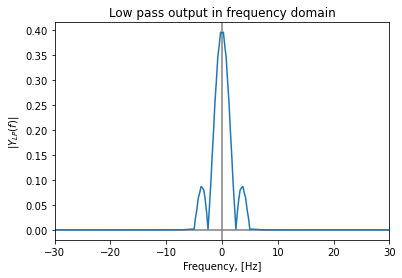

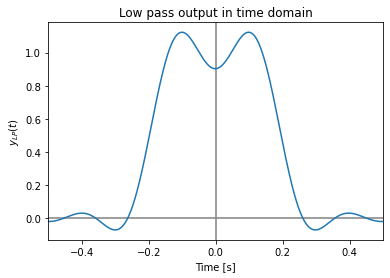

In [7]:
Yl_f = Hl_f*Xl_f

# Plot the magnitude spectrum
plt.title('Low pass output in frequency domain')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(Yl_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|Y_{LP}(f)|$')
plt.show()

yl_t = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(Yl_f)))/dt

# Plot the signal
plt.title('Low pass output in time domain')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,np.real(yl_t))
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{LP}(t)$')
plt.show()

## Band pass filter response to band pass input
Consider an input band pass RF pulse created by multiplying the low pass rectangular pulse with a cosine signal of frequency $f_{c}$
$$
\begin{align*}
x_{BP}(t) \begin{cases}
&= A\cos(2\pi f_{c}t), & \dfrac{-t_{d}}{2}<t<\dfrac{t_{d}}{2}\\
&= 0, & |t|\geq \dfrac{t_{d}}{2}
\end{cases}
\end{align*}
$$
is passed through a band pass filter having impulse response
$$
h_{BP}(t) = 2B\,\mathrm{sinc}(2B\,t)\cos(2\pi f_{c}t)
$$
where $2B$ is the filter bandwidth.

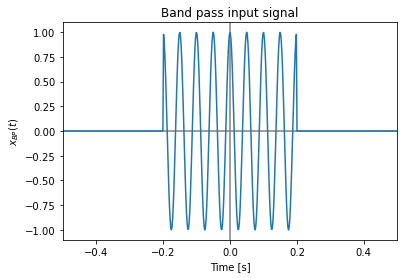

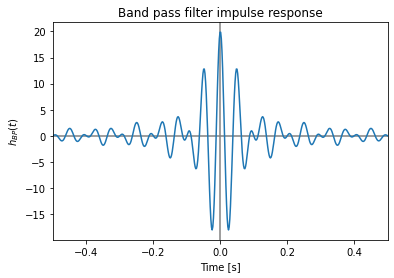

In [8]:
# Define carrier signal
fc = 20
cos_t = np.cos(2*np.pi*fc*t)

# Define bandpass signal
x_t = xl_t*cos_t

# Plot the signal
plt.title('Band pass input signal')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,x_t)
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$x_{BP}(t)$')
plt.show()

# Define a sinc centered at t = 0
s_t = 2*B*np.sinc(2*B*t)
h_t = 2*s_t*np.cos(2*np.pi*fc*t)

# Plot the signal
plt.title('Band pass filter impulse response')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,h_t)
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$h_{BP}(t)$')
plt.show()

The Fourier transform for the band pass input pulse can be expressed as
$$
\begin{align*}
X_{BP}(f) &= \int_{-\infty}^{\infty} A\ \mathrm{rect}(t)\ \dfrac{1}{2}\left[\exp\left(j2\pi f_{c}t\right)+\exp\left(-j2\pi f_{c}t\right)\right]\ \exp\left(-j2\pi ft\right)dt\\
&= \dfrac{1}{2}\int_{-\infty}^{\infty} A\ \mathrm{rect}(t)\ \left(\exp\left(-j2\pi [f-f_{c}]t\right)+\exp\left(-j2\pi [f+f_{c}]t\right)\right)dt\\
&= \dfrac{At_{d}}{2}\left[\mathrm{sinc}(t_{d}[f-f_{c}])+\mathrm{sinc}(t_{d}[f+f_{c}])\right]
\end{align*}
$$
and the Fourier transform for the band pass filter will be
$$
H_{BP}(f) = \begin{cases}
& 1,&\ f_{c}-B<f<f_{c}+B\\
& 0,&\ |f|>B
\end{cases}
$$

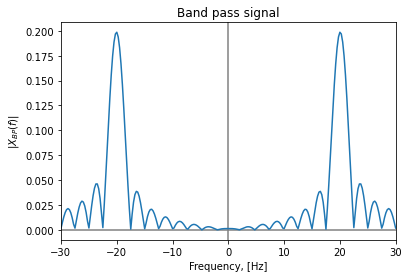

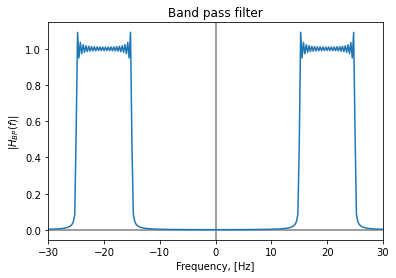

In [9]:
# Calculate FFT. 
X_f = np.fft.fftshift(np.fft.fft(x_t))*dt
H_f = np.fft.fftshift(np.fft.fft(h_t))*dt

# Plot the magnitude spectrum
plt.title('Band pass signal')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(X_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|X_{BP}(f)|$')
plt.show()

# Plot the magnitude spectrum
plt.title('Band pass filter')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(H_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|H_{BP}(f)|$')
plt.show()

#### Band pass output response
The output response can be determined by multiplying the Fourier transforms of the input pulse and the filter.
$$
\begin{align*}
Y_{BP}(f) &= X_{BP}(f)\, H_{BP}(f)\\
&= \begin{cases}
& \dfrac{At_{d}}{2}\left[\mathrm{sinc}(t_{d}[f-f_{c}])+\mathrm{sinc}(t_{d}[f+f_{c}])\right],&\ f_{c}-B<|f|<f_{c}+B\\
&0,&\ |f|>B
\end{cases}
\end{align*}
$$
and its response in time domain will be
$$
y_{BP}(t) = F^{-1}[Y_{BP}(f)]
$$

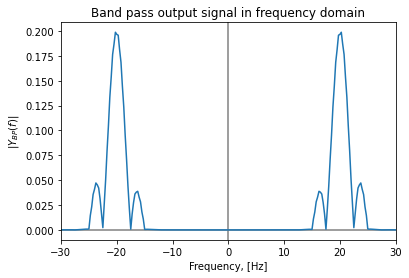

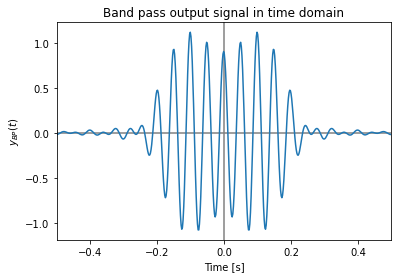

In [10]:
Y_f = X_f*H_f

# Plot the magnitude spectrum
plt.title('Band pass output signal in frequency domain')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(Y_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|Y_{BP}(f)|$')
plt.show()

#y1_t = np.convolve(x_t,h_t,'same')*dt
y_t = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(Y_f)))/dt

# Plot the signal
plt.title('Band pass output signal in time domain')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,np.real(y_t))
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{BP}(t)$')
plt.show()

## Complex representation
Since the bandpass transfer function can be represented as
$$
H_{BP}(f) = \dfrac{1}{2}H_{Z}(f-f_{c})+\dfrac{1}{2}H_{Z}^{*}(-f-f_{c})
$$
it follows that the Fourier transform of the complex envelope of the band pass filter will be
$$
H_{Z}(f) = \begin{cases}
& 2,&\ -B<f<B\\
& 0,&\ |f|>B
\end{cases}
$$

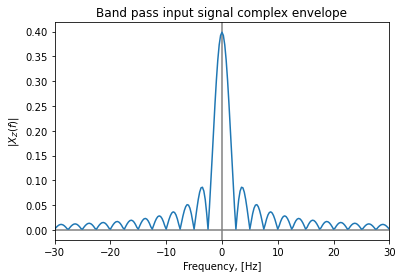

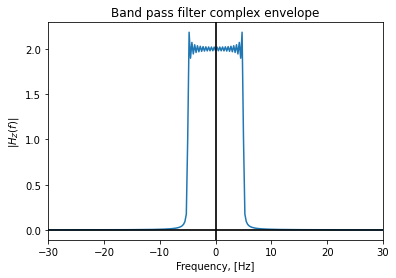

In [11]:
# Complex envelope of bandpass input
xz_t = xl_t

# Complex envelope of bandpass filter
hz_t = 2*s_t

# Fourier transform of complex envelope
XZ_f = np.fft.fftshift(np.fft.fft(xz_t))*dt
HZ_f = np.fft.fftshift(np.fft.fft(hz_t))*dt

# Plot the magnitude spectrum
plt.title('Band pass input signal complex envelope')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(XZ_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|X_{Z}(f)|$')
plt.show()

# Plot the magnitude spectrum
plt.title('Band pass filter complex envelope')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(HZ_f))
plt.axvline(color='black')
plt.axhline(color='black')
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|H_{Z}(f)|$')
plt.show()

#### Complex envelope output response
The complex envelope of the band pass output response corresponds to the output response of the low pass filter.

In frequency domain,
$$
Y_{Z}(f) = \dfrac{1}{2}\,X_{Z}(f) \,H_{Z}(f)
$$

In time domain,
$$
y_{Z}(t) = \dfrac{1}{2}x_{Z}(t) * h_{Z}(t)
$$

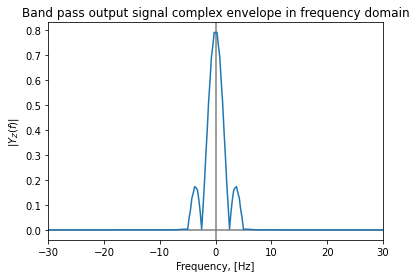

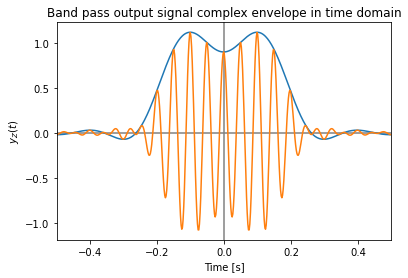

In [12]:
# Output response of complex envelope
YZ_f = HZ_f*XZ_f

# Plot the magnitude spectrum
plt.title('Band pass output signal complex envelope in frequency domain')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(YZ_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|Y_{Z}(f)|$')
plt.show()

# Calculate Fourier inverse of the output response
yz_t = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(YZ_f)))/(2*dt)
yz1_t = 0.5*np.convolve(xz_t,hz_t,'same')*dt

# Plot the signal
plt.title('Band pass output signal complex envelope in time domain')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,np.real(yz_t))
#plt.plot(t,yz1_t)
plt.plot(t,np.real(y_t))
plt.xlabel('Time [s]')
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{Z}(t)$')
plt.show()

## Example problem

The following bandpass signal with a complex envelope given as
$$
x_{Z}(t) = 3je^{-j2\pi 6t} + 2je^{-j2\pi 4t} + 1je^{-j2\pi 2t} + 3e^{j2\pi 2t} + 5e^{j2\pi 4t} + 4e^{j2\pi 6t}
$$
is passed through a bandpass filter whose complex envelope is given by the following impulse response
$$
h_{Z}(t) = 20\,\mathrm{sinc}(10t)
$$

(a) Determine the Fourier transform and plot the amplitude spectrum of the signal $x(t)$.

(b) Determine the transfer function and plot the amplitude spectrum of the filter $h(t)$. What is the bandwidth of the filter?

(c) Determine the complex envelope of the output signal. 

(d) Using a carrier frequency of $f_{c}=10\,\mathrm{Hz}$, determine the Fourier transform of the bandpass output signal, and plot its amplitude spectrum. 

### Solution
#### Part (a)
The complex envelope is expressed as a sum of complex exponentials. 
$$
\begin{align*}
x_{Z}(t) &=  3e^{j2\pi 2t} + 5e^{j2\pi 4t} + 4e^{j2\pi 6t} + j\left[1e^{-j2\pi 2t} + 2e^{-j2\pi 4t} + 3e^{-j2\pi 6t} \right]\\
&= x_{I}(t) + jx_{Q}(t)
\end{align*}
$$
Thus, the Fourier transform of the complex envelope of the bandpass signal is
$$
\begin{align*}
X_{Z}(f) &= X_{I}(f) + jX_{Q}(f)\\
\\
&= 3\,\delta(f-2) + 5\,\delta(f-4) + 4\,\delta(f-6)\\
&+ j[1\,\delta(f+2) + 2\,\delta(f+4) + 3\,\delta(f+6)]\\
\\
X_{Z}(f)  &=  3\delta(f-2) + 5\delta(f-4) + 4\delta(f-6)\\ 
&+ 1e^{j90^{\circ}}\delta(f+2) + 2\,e^{j90^{\circ}}\,\delta(f+4) + 3\,e^{j90^{\circ}}\,\delta(f+6) 
\end{align*}
$$

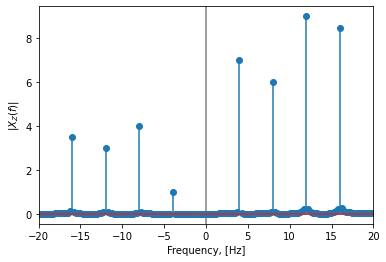

In [13]:
# Define the input signal
xz_t = 1j*1*np.exp(-1j*2*np.pi*4*t) + 1j*4*np.exp(-1j*2*np.pi*8*t) + 1j*3*np.exp(-1j*2*np.pi*12*t) + 1j*3.5*np.exp(-1j*2*np.pi*16*t) + 7*np.exp(1j*2*np.pi*4*t)  + 6*np.exp(1j*2*np.pi*8*t) + 9*np.exp(1j*2*np.pi*12*t) + 8.5*np.exp(1j*2*np.pi*16*t)

# Calculate FFt
XZ_f = np.fft.fftshift(np.fft.fft(xz_t))/N

#  Plot the magnitude spectrum
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,np.abs(XZ_f))
plt.xlim(-20,20)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|X_{Z}(f)|$')
plt.show()

#### Part (b)
The impulse response is of the form
$$
h_{Z}(t) = 2\times (2\times 5)\,\mathrm{sinc}(2\times 5t)
$$
Thus, the transfer function of the complex envelope of the bandpass filter is
$$
H_{Z}(f) = \begin{cases}
& 2,&\ |f|<5\\
& 0,&\ |f|>5
\end{cases}
$$
The bandwidth of the complex envelope of the filter is $B=5\,\mathrm{Hz}$. 

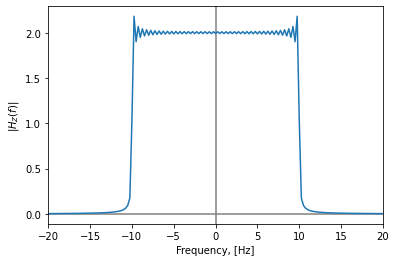

In [14]:
# Define impulse response
hz_t = 40*np.sinc(20*t)

# Calculate FFT
HZ_f = np.fft.fftshift(np.fft.fft(hz_t))*dt

#  Plot the magnitude spectrum
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,np.abs(HZ_f))
plt.xlim(-20,20)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|H_{Z}(f)|$')
plt.show()

#### Part (d)
The Fourier transform of the complex envelope of the output response is
$$
\begin{align*}
Y_{Z}(f) &= H_{Z}(f)X_{Z}(f)\\
\\
&= 2\left[3\delta(f-2) + 5\delta(f-4) + 4\delta(f-6)\right]\\ 
&+ 2\left[1e^{j90^{\circ}}\delta(f+2) + 2\,e^{j90^{\circ}}\,\delta(f+4) + 3\,e^{j90^{\circ}}\,\delta(f+6) \right]\\ 
\\
Y_{Z}(f) &=  6\delta(f-2) + 10\delta(f-4)\\
&+ 2e^{j90^{\circ}}\delta(f+2) + 4e^{j90^{\circ}}\delta(f+4)
\end{align*}
$$
The $f=\pm 6\,\mathrm{Hz}$ component is filtered out.

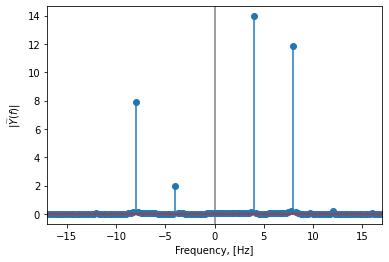

In [15]:
# Calculate FFT
YZ_f = XZ_f*HZ_f

#  Plot the magnitude spectrum
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,np.abs(YZ_f))
plt.xlim(-17,17)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|\widetilde{Y}(f)|$')
plt.show()

#### Part (d)
or a carrier frequency of $f_{c}=10\,\mathrm{Hz}$, the bandpass output response is
$$
\begin{align*}
Y(f) &= H(f)X(f)\\
\\
&= \dfrac{1}{2}\left[X_{Z}(f-f_{c})+X_{Z}^{*}(-f-f_{c})\right]\times \dfrac{1}{2}\left[H_{Z}(f-f_{c})+H_{Z}^{*}(-f-f_{c})\right]\\
\\
&= \dfrac{1}{4}\left[X_{Z}(f-f_{c})\times [H_{Z}(f-f_{c})\right] + \dfrac{1}{4}\left[X_{Z}(f-f_{c})\times H_{Z}^{*}(-f-f_{c})\right] \\
&+ \dfrac{1}{4}\left[X_{Z}^{*}(-f-f_{c})\times [H_{Z}(f-f_{c})\right] + \dfrac{1}{4}\left[X_{Z}^{*}(-f-f_{c})\times H_{Z}^{*}(-f-f_{c})\right]
\end{align*}
$$
Since both $X_{z}(f)$ and $H_{Z}(f)$ are low pass, the cross product terms,
$$
X_{Z}^{*}(-f-f_{c})\times H_{Z}(f-f_{c}) = X_{Z}(f-f_{c})\times H_{Z}^{*}(-f-f_{c}) = 0
$$
Therefore,
$$
Y(f) = \dfrac{1}{4}\left[X_{Z}(f-f_{c})\times [H_{Z}(f-f_{c})\right] +  \dfrac{1}{4}\left[X_{Z}^{*}(-f-f_{c})\times H_{Z}^{*}(-f-f_{c})\right]
$$
where
$$
\begin{align*}
X_{Z}(f-f_{c}) &= X_{I}(f-f_{c}) + j X_{Q}(f-f_{c})\\
&= 3\,\delta(f-2-10) + 5\,\delta(f-4-10) + 4\,\delta(f-6-10)\\
&+ j[1\,\delta(f+2-10) + 2\,\delta(f+4-10) + 3\,\delta(f+6-10)]\\
\\
X_{Z}(f-f_{c}) &= 3\delta(f-12) + 5\delta(f-14) + 4\delta(f-16)\\ 
&+ 1e^{j\pi/2}\delta(f-8) + 2\,e^{j\pi/2}\,\delta(f-6) + 3\,e^{j\pi/2}\,\delta(f-4)\\ 
\\
X_{Z}^{*}(-f-f_{c}) &= X_{I}(f+f_{c}) - j X_{Q}(f+f_{c})\\
&= 3\,\delta(f-2+10) + 5\,\delta(f-4+10) + 4\,\delta(f-6+10)\\
&- j[1\,\delta(f+2+10) + 2\,\delta(f+4+10) + 3\,\delta(f+6+10)]\\
\\
X^{*}_{Z}(-f-f_{c})  &=  3\delta(f+8) + 5\delta(f+6) + 4\delta(f+4)\\ 
&+ 1e^{-j\pi/2}\delta(f+12) + 2\,e^{-j\pi/2}\,\delta(f+14) + 3\,e^{-j\pi/2}\,\delta(f+16) 
\end{align*}
$$
and
$$
\begin{align*}
H_{Z}(f-f_{c}) &= \begin{cases}
& 1,\ & -B+f_{c}<f<B+f_{c}\\
& 0,\ & \mathrm{otherwise}
\end{cases}\\
&= \begin{cases}
& 1,\ & -5+10<f<5+10\\
& 0,\ & \mathrm{otherwise}
\end{cases}\\
H_{Z}(f-f_{c}) &= \begin{cases}
& 1,\ & 5<f<10\\
& 0,\ & \mathrm{otherwise}
\end{cases}\\
\\
H^{*}_{Z}(-f-f_{c}) &= \begin{cases}
& 1,\ & -B-f_{c}<f<B-f_{c}\\
& 0,\ & \mathrm{otherwise}
\end{cases}\\
&= \begin{cases}
& 1,\ & -5-10<f<5-10\\
& 0,\ & \mathrm{otherwise}
\end{cases}\\
H^{*}_{Z}(-f-f_{c}) &= \begin{cases}
& 1,\ & -15<f<-5\\
& 0,\ & \mathrm{otherwise}
\end{cases}
\end{align*}
$$
Thus,
$$
\begin{align*}
Y(f) &= \dfrac{1}{4}\left[X_{Z}(f-f_{c})\times [H_{Z}(f-f_{c})\right] +  \dfrac{1}{4}\left[X_{Z}^{*}(-f-f_{c})\times H_{Z}^{*}(-f-f_{c})\right]\\
\\
&=\dfrac{1}{4}\left[\left(3\delta(f-12) + 5\delta(f-14) + 1\,e^{j\pi/2}\delta(f-8) + 2\,e^{j\pi/2}\,\delta(f-6)\right)\times 2\right]\\
&+ \dfrac{1}{4}\left[\left(3\delta(f+8) + 5\delta(f+6) + 1\,e^{-j\pi/2}\delta(f+12) + 2\,e^{-j\pi/2}\,\delta(f+14)\right)\times 2\right]\\
\\
Y(f) &= 1.5\,\delta(f-12) + 2.5\,\delta(f-14) + 0.5\,e^{j\pi/2}\delta(f-8) + 1\,e^{j\pi/2}\,\delta(f-6)\\ 
&+ 1.5\,\delta(f+8) + 2.5\,\delta(f+6) + 0.5\,e^{-j\pi/2}\delta(f+12) + 1\,e^{-j\pi/2}\,\delta(f+14)
\end{align*}
$$

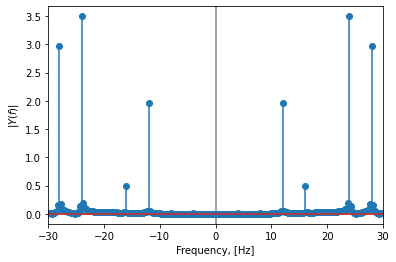

In [16]:
# Define carrier frequency
fc = 20                     # in Hz

# Define the input bandpass signal
x_t = np.real(xz_t)*np.cos(2*np.pi*fc*t)-np.imag(xz_t)*np.sin(2*np.pi*fc*t)

# Define the band pass filter impulse response
h_t = hz_t*np.cos(2*np.pi*fc*t)

# Calculate the band pass output response
y_t = np.convolve(x_t,h_t,'same')*dt 

# Calculate FFT of output bandpass signal
Y_f = np.fft.fftshift(np.fft.fft(y_t))/N

# Verify by mulitplying Fourier transforms
X_f = np.fft.fftshift(np.fft.fft(x_t))/N
H_f = np.fft.fftshift(np.fft.fft(h_t))*dt
Y_f = X_f*H_f

# Plot the magnitude spectrum
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,np.abs(Y_f))
plt.xlim(-30,30)
plt.xlabel('Frequency, [Hz]')
plt.ylabel('$|Y(f)|$')
plt.show()

## Group delay and phase delay
Group delay is the delay that two or more frequency components undergo while passing through a linear system. It is given as
$$
T_{g}(f) = -\dfrac{1}{2\pi} \dfrac{d}{df}\angle{H}(f)
$$
where $\theta(f)$ is the phase response of the system.

Phase delay is the delay a single frequency component, say $f=f_{1}$, undergoes while passing through a system. It is given as
$$
T_{p}(f_{1}) = -\dfrac{\angle{H}(f_{1})}{2\pi f_{1}}
$$

### Example
For a distortionless system, the phase response is a linear function of frequency. Therefore, the group delay of a signal will be constant and equal to the phase delay. In other words, The amount of time delay experienced by one frequency component in the signal will be same as the time delay experienced by all the other frequency components. 

Consider that the following inputs are given to a system having an amplitude and phase response shown below.
$$
\begin{align*}
x_{1}(t) &= \cos(10\pi t) + \cos(16\pi t)\\
x_{2}(t) &= \cos(10\pi t) + \cos(24\pi t)\\
x_{3}(t) &= \cos(18\pi t) + \cos(36\pi t)\\
x_{4}(t) &= \cos(30\pi t) + \cos(42\pi t)
\end{align*}
$$


#### Solution
The system response can be expressed in piecewise form as:
$$
\begin{align*}
|H(f)| &= \begin{cases}
& 2,\ & |f|<10\\
& 1,\ & |f|<20\\
& 0,\ & \mathrm{otherwise}
\end{cases}\\
\\
\angle{H}(f) &= \begin{cases}
& -\dfrac{\pi}{20}f,\ & |f|<15\\
\\
& -\dfrac{3\pi}{4},\ & |f|>15
\end{cases}
\end{align*}
$$
Since the input signal consists of cosine terms, the system output will be of the form
$$
y(t) = A |H(f)|\cos(2\pi f[t-T_{p}(f)])
$$

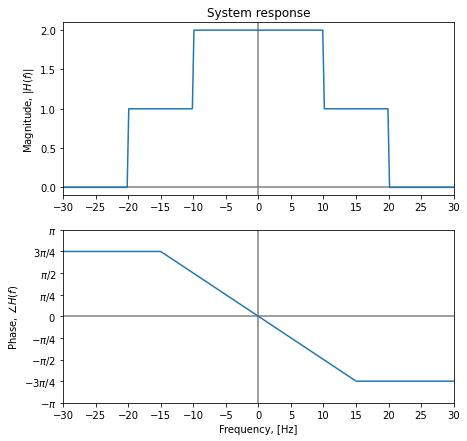

In [17]:
# Define frequency axis
freq = np.linspace(-250,250,2048)

# Define the system magnitude response
mag_H_f = np.piecewise(freq,[(0<np.abs(freq))&(np.abs(freq)<10),(10<np.abs(freq))&(np.abs(freq)<20)],[lambda freq: 2, lambda freq: 1])

# Define the system phase response
arg_H_f = np.piecewise(freq,[(-15<freq)&(freq<15),(freq<-15), (freq>15)],[lambda freq: (-np.pi/20)*freq, lambda freq: 3*np.pi/4, lambda freq: -3*np.pi/4])

# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('System response')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,mag_H_f)
plt.xlim(-30,30)
plt.locator_params(axis='x', nbins=20)
plt.ylabel('Magnitude, $|H(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(freq,arg_H_f)
plt.xlim(-30,30)
plt.locator_params(axis='x', nbins=20)
my_yticks = ['$-\pi$','$-3\pi/4$','$-\pi/2$','$-\pi/4$','$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$']   
plt.yticks([-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],my_yticks) 
plt.ylabel('Phase, $\\angle{H}(f)$')

plt.xlabel('Frequency, [Hz]')
plt.show()

For $x_{1}(t)=\cos(10\pi t)+\cos(16\pi t)$:

There are two frequency components in $x_{1}(t)$: $5\,\mathrm{Hz}$ and $8\,\mathrm{Hz}$. 

Both freqeuncy components will have their amplitude scaled by 2, and their phase linearly shifted. The phase delay will be 
$$
\begin{align*}
T_{p}(f) &= -\dfrac{1}{2\pi}\angle{H}(f)\\ 
&= -\dfrac{1}{2\pi f}\dfrac{-\pi}{20}f\\ 
T_{p}(f) &= \dfrac{1}{40}\,\mathrm{s}
\end{align*}
$$
The corresponding output is
$$
y_{1}(t) = 2\,\cos\left(10\pi\left[t-\dfrac{1}{40}\right]\right) + 2\,\cos\left(16\pi\left[t-\dfrac{1}{40}\right]\right)
$$
Since both frequency components are scaled in amplitude and shifted in time by the same amount, there is no amplitude or phase distortion.

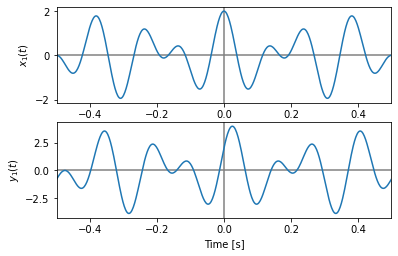

In [18]:
# Plot the input signal
x1_t = np.cos(10*np.pi*t) + np.cos(16*np.pi*t)

# Plot the output signal
y1_t = 2*np.cos(10*np.pi*(t-1/40)) + 2*np.cos(16*np.pi*(t-1/40))


# Plot the signal
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,x1_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$x_{1}(t)$')

plt.subplot(312)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,y1_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{1}(t)$')

plt.xlabel('Time [s]')
plt.show()

For $x_{2}(t)=\cos(10\pi t)+\cos(24\pi t)$:

There are two frequency components in $x_{2}(t)$: $5\,\mathrm{Hz}$ and $12\,\mathrm{Hz}$. 

The $5\,\mathrm{Hz}$ component will have its amplitude scaled by 2, the $12\,\mathrm{Hz}$ component will have its amplitude scaled by 1.

The phase for both frequency components is linearly shifted. The phase delay will be 
$$
\begin{align*}
T_{p}(f) &= -\dfrac{1}{2\pi}\angle{H}(f)\\ 
&= -\dfrac{1}{2\pi f}\dfrac{-\pi}{20}f\\ 
T_{p}(f) &= \dfrac{1}{40}\,\mathrm{s}
\end{align*}
$$
The corresponding output is
$$
y_{2}(t) = 2\,\cos\left(10\pi\left[t-\dfrac{1}{40}\right]\right) + 1\,\cos\left(24\pi\left[t-\dfrac{1}{40}\right]\right)
$$
Since amplitude is scaled by different amount but the time delay is the same, there is amplitude distortion, but no phase distortion.

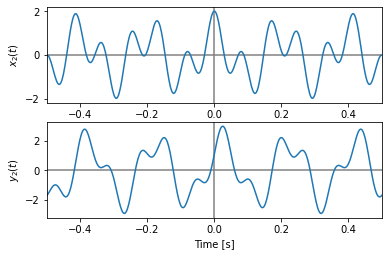

In [19]:
# Plot the input signal
x2_t = np.cos(10*np.pi*t) + np.cos(24*np.pi*t)

# Plot the output signal
y2_t = 2*np.cos(10*np.pi*(t-1/40)) + 1*np.cos(24*np.pi*(t-1/40))

# Plot the signal
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,x2_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$x_{2}(t)$')

plt.subplot(312)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,y2_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{2}(t)$')

plt.xlabel('Time [s]')
plt.show()

For $x_{3}(t)=\cos(18\pi t)+\cos(36\pi t)$:

There are two frequency components in $x_{3}(t)$: $9\,\mathrm{Hz}$ and $18\,\mathrm{Hz}$. 

The $9\,\mathrm{Hz}$ component will have its amplitude scaled by 2, the $18\,\mathrm{Hz}$ component will have its amplitude scaled by 1.

The phase delay for the $9\,\mathrm{Hz}$ component will be 
$$
\begin{align*}
T_{p}(f) &= -\dfrac{1}{2\pi f}\angle{H}(f)\\ 
&= -\dfrac{1}{2\pi f}\dfrac{-\pi}{20}f\\ 
T_{p}(9) &= \dfrac{1}{40}\,\mathrm{s}
\end{align*}
$$
The phase delay for the $18\,\mathrm{Hz}$ component is
$$
\begin{align*}
T_{p}(f) &= -\dfrac{1}{2\pi f}\angle{H}(f)\\
&= -\dfrac{1}{2\pi \times 18}\dfrac{-3\pi}{4}\\
T_{p}(18) &= \dfrac{1}{48}\,\mathrm{s}
\end{align*}
$$
The corresponding output is
$$
y_{3}(t) = 2\,\cos\left(18\pi\left[t-\dfrac{1}{40}\right]\right) + 1\,\cos\left(36\pi\left[t-\dfrac{1}{48}\right]\right)
$$
Since amplitude is scaled by different amount and the time delay is different for each frequency component, there is amplitude distortion and phase distortion.

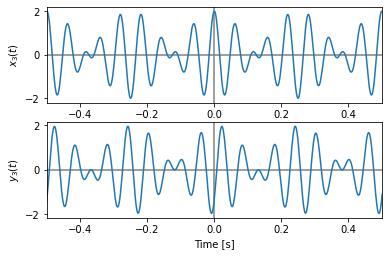

In [20]:
# Plot the input signal
x3_t = np.cos(28*np.pi*t) + np.cos(36*np.pi*t)

# Plot the output signal
y3_t = 1*np.cos(28*np.pi*(t-1/40)) + 1*np.cos(36*np.pi*(t-1/48))

# Plot the signal
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,x3_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$x_{3}(t)$')

plt.subplot(312)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,y3_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{3}(t)$')

plt.xlabel('Time [s]')
plt.show()

For $x_{4}(t)=\cos(30\pi t)+\cos(42\pi t)$:

There are two frequency components in $x_{4}(t)$: $15\,\mathrm{Hz}$ and $21\,\mathrm{Hz}$. 

The $15\,\mathrm{Hz}$ component will have its amplitude scaled by 1, and the $21\,\mathrm{Hz}$ component will be eliminated.

The phase delay for the $15\,\mathrm{Hz}$ component is
$$
\begin{align*}
T_{p}(f) &= -\dfrac{1}{2\pi f}\angle{H}(f)\\
&= -\dfrac{1}{2\pi \times 15}\dfrac{-3\pi}{4}\\
T_{p}(15) &= \dfrac{1}{40}\,\mathrm{s}
\end{align*}
$$
The corresponding output is
$$
y_{4}(t) = 1\,\cos\left(30\pi\left[t-\dfrac{1}{40}\right]\right)
$$

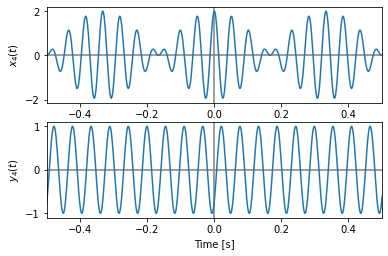

In [21]:
# Plot the input signal
x4_t = np.cos(36*np.pi*t) + np.cos(42*np.pi*t)

# Plot the output signal
y4_t = 1*np.cos(36*np.pi*(t-1/48)) + 0*np.cos(42*np.pi*(t-1/56))

# Plot the signal
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,x4_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$x_{4}(t)$')

plt.subplot(312)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,y4_t)
plt.xlim(-0.5,0.5)
plt.ylabel('$y_{4}(t)$')

plt.xlabel('Time [s]')
plt.show()